## Final Project - Basics of deep learning

---
<br>

### Name and ID:
Student 1: Eyal Pasha, 213957814
<br>
Student 2: Nir Tuttnauer, 208585422

## **Chest X-Ray Images (Pneumonia) Dataset**


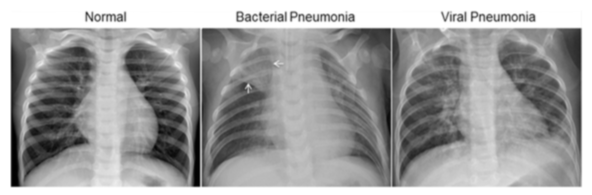

The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Link: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


<br>
<br>
Content:

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

<br>

Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2


## **README**



**Download links**:
* Models & Weights- https://drive.google.com/file/d/1syY6vDG1IkLriRz84W2Mzh5xlcx99dOD/view?usp=share_link
* Dataset- https://data.mendeley.com/datasets/rscbjbr9sj/2

**Usage Guide**:

1.   Download Weights & Models and dataset:

*   use the provided link to download the "models.zip" and "dataset.zip" files.
*   Save it to your local machine.

2.   Upload to Google Drive:
* Go to your [Google Drive](https://drive.google.com).
* Open Your Drives Root Directory
* Upload the "models.zip" and "dataset.zip" files into this folder.

3. Rename the File:
* Make sure the file is named exactly "models.zip" and "dataset.zip" as mentioned in the instructions.

> Like so:

> 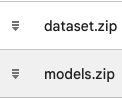





4. Run the "setup" section:
* In the Test Notebook press play the "Setup" section.
* It will ask you to give access premitons to your Drive, You need to connect to the same Drive you uploaded the files to.

5. Run Each Part:
* Once the setup is complete, you can run each part of the notebook as instructed.
* This might involve executing code cells to perform tasks like loading models, processing data, or running tests.

## **Setup**

**Imports**

In [ ]:
import os
import random
import shutil
from google.colab import drive
import shutil
import numpy as np
import zipfile
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import  SGD
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D, Input, Concatenate, UpSampling2D, ReLU)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Functions

In [ ]:
def model_full_report(model,history, test_generator):
    # Plot training and validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Make predictions using the model
    predictions = model.predict(test_generator)

    # Get predicted labels (argmax to get the class with the highest probability)
    predicted_labels = predictions.argmax(axis=1)

    # Get true labels
    true_labels = test_generator.classes

    # Generate a classification report
    report = classification_report(true_labels, predicted_labels)

    # Print the classification report
    print("Classification Report:\n", report)

def save_model(model, model_filename='unnamed.h5'):
    weights_filename = os.path.splitext(model_filename)[0] + '_w.h5'
    model.save(model_filename)
    model.save_weights(weights_filename)

def save_history(history, filename='unnamed.npy'):
    np.save(filename, history)

def load_saved_model(model_filename='unnamed.h5'):
    return load_model(model_filename)

def load_saved_history(filename='unnamed.npy'):
    return np.load(filename, allow_pickle=True).item()

class Config:
    def __init__(self, img_width=256, img_height=256, epochs=10, batch_size=32, learning_rate=0.0001):
        self.img_width = img_width
        self.img_height = img_height
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def generate_data(self, train_data_dir, test_data_dir):
        # Data augmentation for training set
        train_datagen = ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Only rescaling for validation/test set
        test_datagen = ImageDataGenerator(rescale=1. / 255)

        # Generating training set
        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary'
        )

        # Generating validation set
        validation_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary'
        )

        # Generating test set
        test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False  # Ensure the order of predictions matches the order of actual labels
        )

        return train_generator, validation_generator, test_generator


**For Google Drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Data extraction and reorganization**

In [ ]:
# for images
# Specify the path to the zip file and the extraction directory
zip_path = '/content/drive/MyDrive/dataset.zip'
extracted_path = '/content/dataset'
# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

#for models and weights:
zip_path = '/content/drive/MyDrive/models.zip'
extracted_path = '/content/'
# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Function to delete a directory and its contents
def delete_directory(path):
    try:
        shutil.rmtree(path)
        print(f"Directory '{path}' successfully deleted.")
    except FileNotFoundError:
        print(f"Directory '{path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Define the paths to the directories you want to delete
dir_to_delete1 = '/content/dataset/chest_xray/__MACOSX'
dir_to_delete2 = '/content/dataset/chest_xray/val'
dir_to_delete3 = '/content/dataset/chest_xray/chest_xray/val'

# Delete the first directory
delete_directory(dir_to_delete1)

# Move NORMAL images from val to train
src_path_normal = '/content/dataset/chest_xray/val/NORMAL'
dest_path_normal = '/content/dataset/chest_xray/train/NORMAL'

for filename in os.listdir(src_path_normal):
    shutil.move(os.path.join(src_path_normal, filename), os.path.join(dest_path_normal, filename))

# Move PNEUMONIA images from val to val/NORMAL
src_path_pneumonia = '/content/dataset/chest_xray/val/PNEUMONIA'
dest_path_pneumonia = '/content/dataset/chest_xray/val/NORMAL'

for filename in os.listdir(src_path_pneumonia):
    shutil.move(os.path.join(src_path_pneumonia, filename), os.path.join(dest_path_pneumonia, filename))

# Move NORMAL images from chest_xray/val to chest_xray/train
src_path_chest_xray_normal = '/content/dataset/chest_xray/chest_xray/val/NORMAL'
dest_path_chest_xray_normal = '/content/dataset/chest_xray/chest_xray/train/NORMAL'

for filename in os.listdir(src_path_chest_xray_normal):
    shutil.move(os.path.join(src_path_chest_xray_normal, filename), os.path.join(dest_path_chest_xray_normal, filename))

# Move PNEUMONIA images from chest_xray/val to chest_xray/val/NORMAL
src_path_pneumonia_chest_xray = '/content/dataset/chest_xray/chest_xray/val/PNEUMONIA'
dest_path_pneumonia_chest_xray = '/content/dataset/chest_xray/chest_xray/val/NORMAL'

for filename in os.listdir(src_path_pneumonia_chest_xray):
    shutil.move(os.path.join(src_path_pneumonia_chest_xray, filename), os.path.join(dest_path_pneumonia_chest_xray, filename))

# Delete the 'val' folders
delete_directory(dir_to_delete2)
delete_directory(dir_to_delete3)

# Define the paths for the test directory
test_dir = '/content/dataset/chest_xray/chest_xray/test'
src_path_pneumonia_test = os.path.join(test_dir, 'PNEUMONIA')
dest_path_bacterial = os.path.join(test_dir, 'BACTERIAL')
dest_path_viral = os.path.join(test_dir, 'VIRAL')

# Create the BACTERIAL and VIRAL folders
os.makedirs(dest_path_bacterial, exist_ok=True)
os.makedirs(dest_path_viral, exist_ok=True)

# Split images between BACTERIAL and VIRAL based on the presence of words in the filename
for filename in os.listdir(src_path_pneumonia_test):
    src_file_path = os.path.join(src_path_pneumonia_test, filename)

    if "bacteria" in filename.lower():
        dest_file_path = os.path.join(dest_path_bacterial, filename)
    elif "virus" in filename.lower():
        dest_file_path = os.path.join(dest_path_viral, filename)
    else:
        # Skip files that don't contain "bacteria" or "virus" in the filename
        continue

    shutil.move(src_file_path, dest_file_path)

# Delete the 'PNEUMONIA' folder in the test directory
delete_directory(src_path_pneumonia_test)

# Define the paths for the train directory
train_dir = '/content/dataset/chest_xray/chest_xray/train'
src_path_pneumonia_train = os.path.join(train_dir, 'PNEUMONIA')
dest_path_bacterial_train = os.path.join(train_dir, 'BACTERIAL')
dest_path_viral_train = os.path.join(train_dir, 'VIRAL')

# Create the BACTERIAL and VIRAL folders in the train directory
os.makedirs(dest_path_bacterial_train, exist_ok=True)
os.makedirs(dest_path_viral_train, exist_ok=True)

# Split images between BACTERIAL and VIRAL based on the presence of words in the filename
for filename in os.listdir(src_path_pneumonia_train):
    src_file_path = os.path.join(src_path_pneumonia_train, filename)

    if "bacteria" in filename.lower():
        dest_file_path = os.path.join(dest_path_bacterial_train, filename)
    elif "virus" in filename.lower():
        dest_file_path = os.path.join(dest_path_viral_train, filename)
    else:
        # Skip files that don't contain "bacteria" or "virus" in the filename
        continue

    shutil.move(src_file_path, dest_file_path)

# Delete the 'PNEUMONIA' folder in the train directory
delete_directory(src_path_pneumonia_train)

# Function to count files in a directory
def count_files_in_directory(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Define paths
dataset_path = "/content/dataset/chest_xray/chest_xray"
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val")

# Create VAL folder if not exists
if not os.path.exists(val_path):
    os.makedirs(val_path)

# Define the number of images to move to the validation set
num_images_val = 345

# Define the new number of images in the training set
new_num_images_train = 1000

# Function to move random images from the train directory to the val directory
def move_random_images(source_dir, dest_dir, num_images):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    files = os.listdir(source_dir)
    selected_files = random.sample(files, num_images)

    for file in selected_files:
        source_path = os.path.join(source_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(source_path, dest_path)

# Move random images to the validation set
val_bacterial_path = os.path.join(val_path, "BACTERIAL")
val_normal_path = os.path.join(val_path, "NORMAL")
val_viral_path = os.path.join(val_path, "VIRAL")

move_random_images(os.path.join(train_path, "BACTERIAL"), val_bacterial_path, num_images_val)
move_random_images(os.path.join(train_path, "NORMAL"), val_normal_path, num_images_val)
move_random_images(os.path.join(train_path, "VIRAL"), val_viral_path, num_images_val)

# Limit the number of images in the training set
def limit_images_in_directory(directory, new_num_images):
    files = os.listdir(directory)
    excess_files = files[new_num_images:]

    for file in excess_files:
        file_path = os.path.join(directory, file)
        os.remove(file_path)

# Limit the number of images in the training set for each class
limit_images_in_directory(os.path.join(train_path, "BACTERIAL"), new_num_images_train)
limit_images_in_directory(os.path.join(train_path, "NORMAL"), new_num_images_train)
limit_images_in_directory(os.path.join(train_path, "VIRAL"), new_num_images_train)

# Display the counts after the changes
bacterial_count_train = count_files_in_directory(os.path.join(train_path, "BACTERIAL"))
normal_count_train = count_files_in_directory(os.path.join(train_path, "NORMAL"))
viral_count_train = count_files_in_directory(os.path.join(train_path, "VIRAL"))

bacterial_count_val = count_files_in_directory(val_bacterial_path)
normal_count_val = count_files_in_directory(val_normal_path)
viral_count_val = count_files_in_directory(val_viral_path)

print("\n--- After Modifications ---")
print("\nNumber of photos in BACTERIAL directory (Train):", bacterial_count_train)
print("Number of photos in NORMAL directory (Train):", normal_count_train)
print("Number of photos in VIRAL directory (Train):", viral_count_train)

print("\nNumber of photos in BACTERIAL directory (Validation):", bacterial_count_val)
print("Number of photos in NORMAL directory (Validation):", normal_count_val)
print("Number of photos in VIRAL directory (Validation):", viral_count_val)

# unmount the drive
drive.flush_and_unmount()


Directory '/content/dataset/chest_xray/__MACOSX' successfully deleted.
Directory '/content/dataset/chest_xray/val' successfully deleted.
Directory '/content/dataset/chest_xray/chest_xray/val' successfully deleted.
Directory '/content/dataset/chest_xray/chest_xray/test/PNEUMONIA' successfully deleted.
Directory '/content/dataset/chest_xray/chest_xray/train/PNEUMONIA' successfully deleted.

--- After Modifications ---

Number of photos in BACTERIAL directory (Train): 1000
Number of photos in NORMAL directory (Train): 1000
Number of photos in VIRAL directory (Train): 1000

Number of photos in BACTERIAL directory (Validation): 345
Number of photos in NORMAL directory (Validation): 345
Number of photos in VIRAL directory (Validation): 345


## **Task 1 - Binary Classifiaction**

Full Training Report

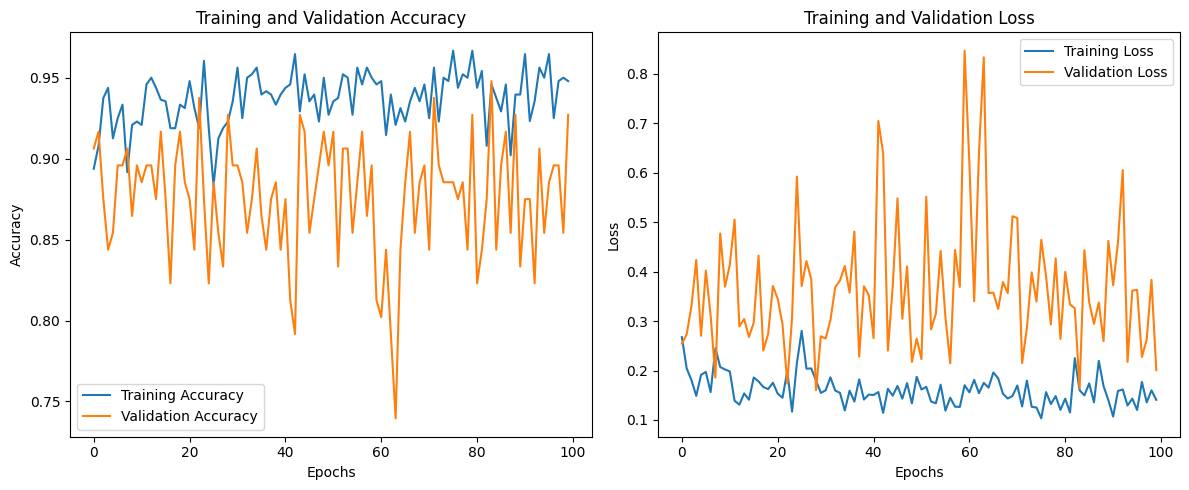

**Preping the data**

In [ ]:
# Set the paths
train_data_dir = '/content/dataset/chest_xray/train'
test_data_dir = '/content/dataset/chest_xray/test'

# Define parameters
img_width, img_height = 256, 256
epochs = 50
batch_size = 32
learning_rate = 0.0001

# Data augmentation for training set
train_datagen = ImageDataGenerator(
rescale=1. / 255,
rotation_range=15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

# Only rescaling for validation/test set
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generating training set
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='binary'
)

# Generating validation set
validation_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='binary',
shuffle=False # Ensure the order of predictions matches the order of actual labels
)

Found 5224 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Load Model

In [ ]:
# Load the trained model with full dataset weights
model_full = load_model('models/1/binary_classification_model_full_dataset.h5')
model_full.load_weights('models/1/binary_classification_weights_full_dataset.h5')

1/1 [==============================] - 0s 28ms/step


<ipython-input-18-03a8eacd8c89>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = int(np.round(prediction[0]))


1/1 [==============================] - 0s 47ms/step


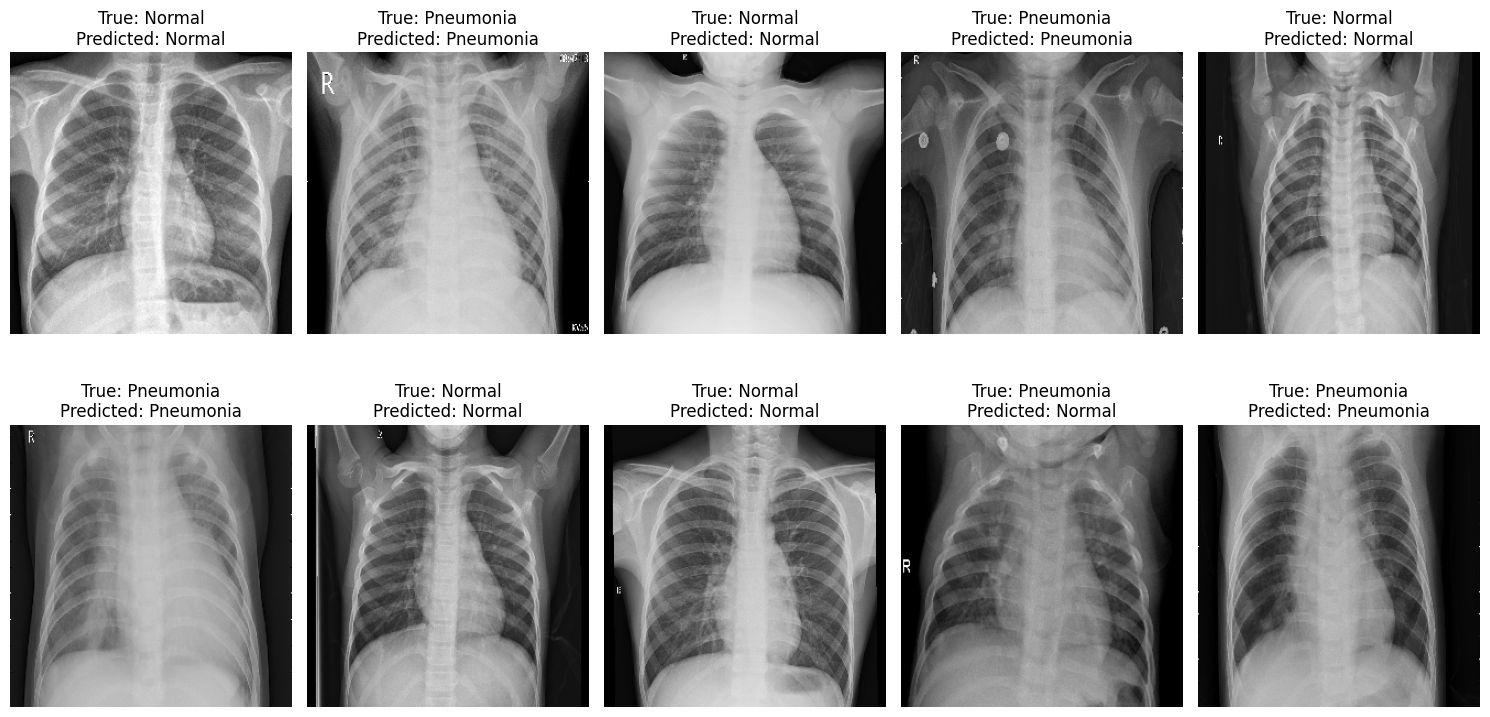

In [ ]:
# Get class labels
class_labels = {0: 'Normal', 1: 'Pneumonia'}

# Get 10 random images from the test set
random_indices = np.random.choice(len(test_generator.filenames), size=10, replace=False)

# Display the images and predictions
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
  img_path = os.path.join(test_data_dir, test_generator.filenames[idx])
  img = image.load_img(img_path, target_size=(img_width, img_height), color_mode='rgb')
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0 # Rescale pixel values
  true_label = test_generator.classes[idx]

# Make predictions
  prediction = model_full.predict(img_array)
  predicted_label = int(np.round(prediction[0]))

# Display the image with true and predicted labels
  plt.subplot(2, 5, i+1)
  plt.imshow(img, cmap='gray')
  plt.title(f'True: {class_labels[true_label]}\nPredicted: {class_labels[predicted_label]}')
  plt.axis('off')

plt.tight_layout()
plt.savefig('binary_predictions.png')
plt.show()

<ipython-input-19-81ea92064ae3>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_full.predict_generator(test_generator, verbose=1)


20/20 [==============================] - 8s 302ms/step


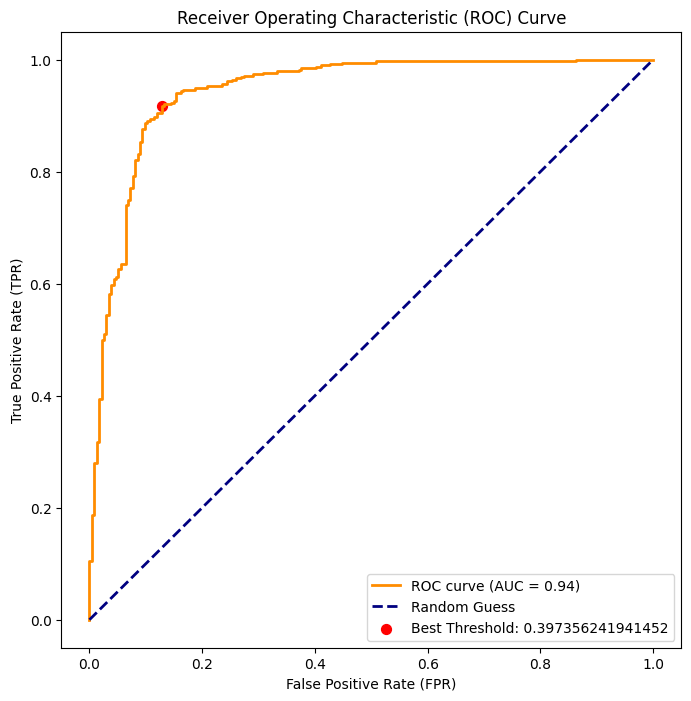

Best Threshold (Youden's J): 0.397356241941452


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate predictions and calculate accuracy
predictions = model_full.predict_generator(test_generator, verbose=1)
true_labels = test_generator.classes

# Get true positive rate (Sensitivity) and false positive rate
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Find the threshold that maximizes Youden's J statistic
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]

# Plot the ROC curve with the selected threshold
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', s=50, label=f'Best Threshold: {best_threshold}')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(f"Best Threshold (Youden's J): {best_threshold}")


# **Task 2 - Multi-Class**

**Data prep**

In [ ]:
# Set paths
train_data_dir_multi = '/content/dataset/chest_xray/chest_xray/train'
test_data_dir_multi = '/content/dataset/chest_xray/chest_xray/test'

# Data generator with data augmentation for training
train_datagen_multi = ImageDataGenerator(rescale=1./255,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         rotation_range=15)  # Experiment with rotation range


# Data generator for validation and test (no augmentation)
val_test_datagen_multi = ImageDataGenerator(rescale=1./255)

# Parameters
img_width, img_height = 256, 256
batch_size = 16  # Adjusted for a smaller batch size

# Data generators with black and white images
train_generator_multi = train_datagen_multi.flow_from_directory(train_data_dir_multi,
                                                                target_size=(img_width, img_height),
                                                                batch_size=batch_size,
                                                                color_mode='grayscale',
                                                                # Set to 'grayscale' class_mode='categorical',  # Set to 'categorical'
                                                                classes=['NORMAL', 'BACTERIAL','VIRAL'])  # Specify classes

val_generator_multi = val_test_datagen_multi.flow_from_directory(test_data_dir_multi,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',  # Set to 'grayscale'
                                                    class_mode='categorical',  # Set to 'categorical'
                                                    classes=['NORMAL', 'BACTERIAL', 'VIRAL'])  # Specify classes

test_generator_multi = val_test_datagen_multi.flow_from_directory(test_data_dir_multi,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',  # Set to 'grayscale'
                                                    class_mode='categorical',  # Set to 'categorical'
                                                    classes=['NORMAL', 'BACTERIAL', 'VIRAL'])  # Specify classes

# Load the trained weights for the multi-class model
model_transfer_full = load_model('/content/models/2/multi_full.h5')
model_transfer_full.load_weights('/content/models/2/multi_full_w.h5')
if model_transfer_full is None:
    raise Exception('Model not found')

Found 2999 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


**Full report:**

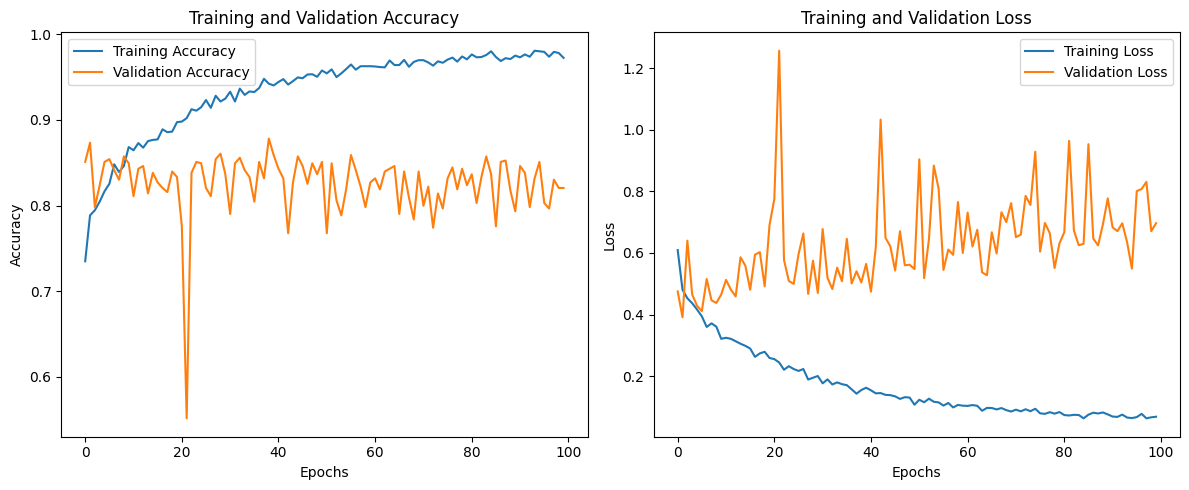

39/39 [==============================] - 4s 102ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.32      0.34       234
           1       0.37      0.38      0.37       242
           2       0.21      0.24      0.23       148

    accuracy                           0.33       624
   macro avg       0.32      0.31      0.31       624
weighted avg       0.33      0.33      0.33       624



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

hist_transfer_full = load_saved_history('/content/models/2/multi_full.npy')

# Plot training and validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_transfer_full.history['accuracy'], label='Training Accuracy')
plt.plot(hist_transfer_full.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist_transfer_full.history['loss'], label='Training Loss')
plt.plot(hist_transfer_full.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

predictions = model_transfer_full.predict(test_generator_multi)

# Get predicted labels (argmax to get the class with the highest probability)
predicted_labels = predictions.argmax(axis=1)

# Get true labels
true_labels = test_generator_multi.classes

# Generate a classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:\n", report)


**Test code:**

1/1 [==============================] - 3s 3s/step


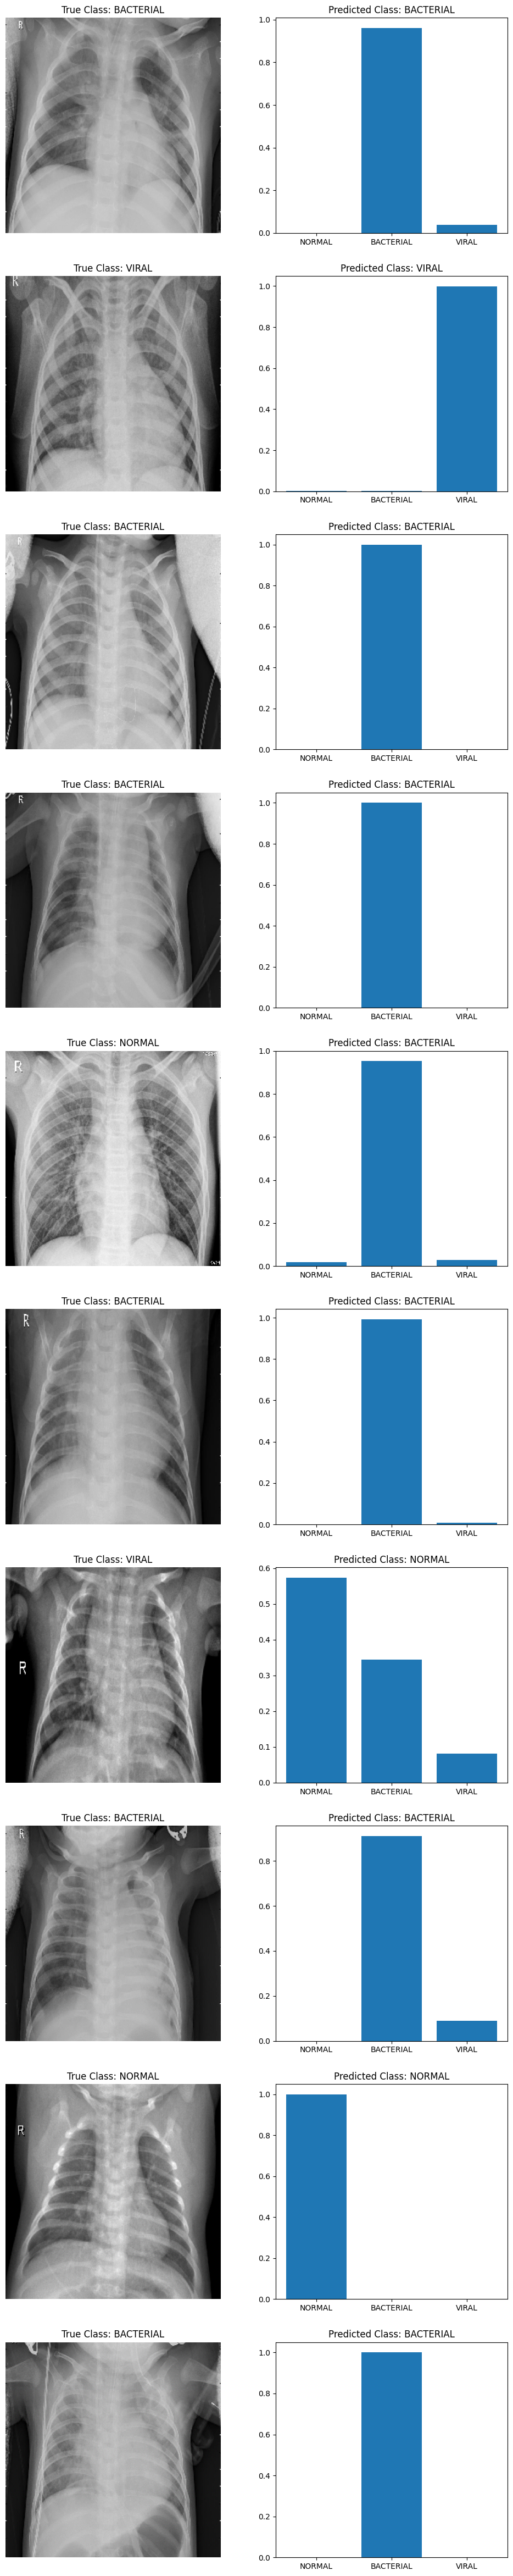

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test images and labels
test_images, test_labels = test_generator_multi.next()

# Select 10 random images and labels
indices = np.random.choice(len(test_labels), size=10, replace=False)
selected_images = test_images[indices]
selected_labels = test_labels[indices]

# Predict the classes for the selected images
predictions = model_transfer_full.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Map numerical labels to class names
class_mapping = {0: 'NORMAL', 1: 'BACTERIAL', 2: 'VIRAL'}

# Create a single plot with each row representing an image
plt.figure(figsize=(12, 6 * len(selected_images)))

for i in range(len(selected_images)):
    plt.subplot(len(selected_images), 2, 2*i+1)
    plt.imshow(selected_images[i].reshape((img_width, img_height)), cmap='gray')
    plt.title('True Class: ' + class_mapping[np.argmax(selected_labels[i])])
    plt.axis('off')

    plt.subplot(len(selected_images), 2, 2*i+2)
    plt.bar(range(3), predictions[i], tick_label=list(class_mapping.values()))
    plt.title('Predicted Class: ' + class_mapping[predicted_classes[i]])

# Save the figure
plt.savefig('multi_class_predictions_combined.png')
plt.show()


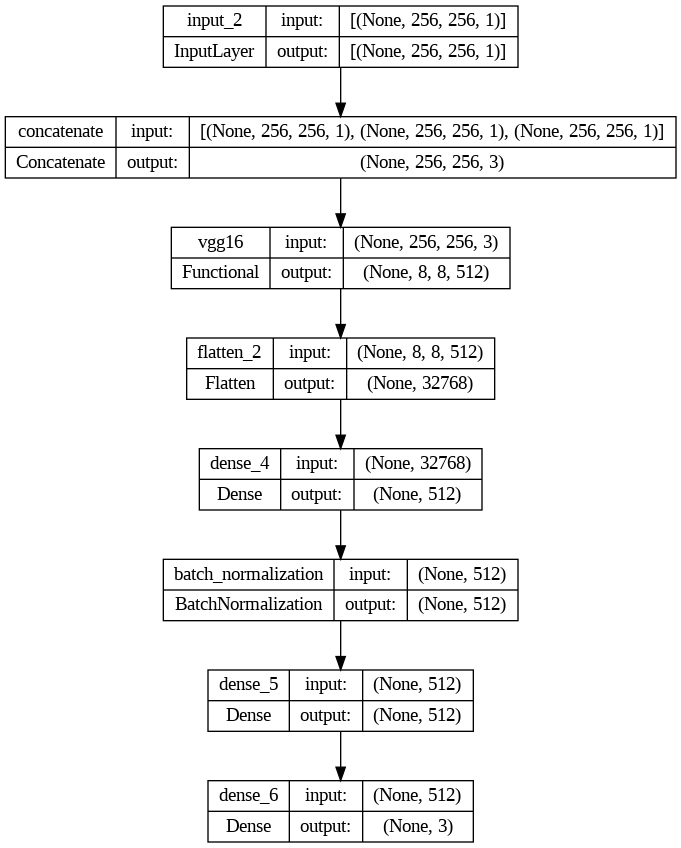

In [ ]:
from keras.src.utils import plot_model

# We want to plot the model
plot_model(model_transfer_full, to_file='model.png', show_shapes=True, show_layer_names=True)

# **Task 3 - KNN**

  0%|          | 0/39 [00:00<?, ?it/s]

1/1 [==============================] - 0s 165ms/step


  3%|▎         | 1/39 [00:00<00:13,  2.77it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 2/39 [00:00<00:11,  3.17it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 3/39 [00:00<00:09,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 4/39 [00:01<00:08,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 5/39 [00:01<00:08,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 6/39 [00:01<00:08,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 7/39 [00:01<00:07,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 8/39 [00:02<00:07,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 9/39 [00:02<00:07,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 10/39 [00:02<00:06,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 11/39 [00:02<00:06,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 12/39 [00:02<00:06,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 13/39 [00:03<00:05,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 14/39 [00:03<00:05,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 15/39 [00:03<00:05,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 16/39 [00:03<00:04,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 17/39 [00:04<00:05,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 18/39 [00:04<00:05,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 19/39 [00:04<00:04,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 20/39 [00:04<00:04,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 21/39 [00:05<00:04,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 22/39 [00:05<00:04,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 23/39 [00:05<00:03,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 24/39 [00:05<00:03,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 25/39 [00:05<00:03,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 26/39 [00:06<00:02,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 27/39 [00:06<00:02,  4.62it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 28/39 [00:06<00:02,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 29/39 [00:06<00:02,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 30/39 [00:07<00:01,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 31/39 [00:07<00:01,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 32/39 [00:07<00:01,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 33/39 [00:07<00:01,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 34/39 [00:08<00:01,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 35/39 [00:08<00:00,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 36/39 [00:08<00:00,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 37/39 [00:08<00:00,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 38/39 [00:09<00:00,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████| 39/39 [00:09<00:00,  4.13it/s]


1/1 [==============================] - 1s 891ms/step
Predicted Class for the New Image: 1


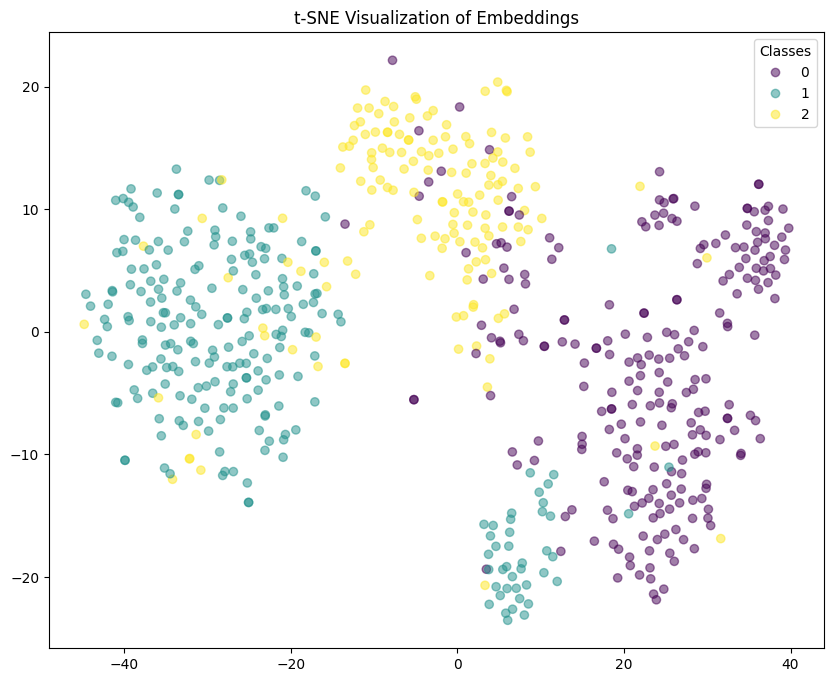

In [ ]:
# Extract embeddings from the last layer of the model
embedding_model = Model(inputs=model_transfer_full.input, outputs=model_transfer_full.layers[-2].output)

# Get embeddings for all images in the test set
embeddings = []
labels = []

for batch in tqdm(range(test_generator_multi.samples // 16)):
    test_images, test_labels = next(test_generator_multi)
    batch_embeddings = embedding_model.predict(test_images)
    embeddings.extend(batch_embeddings)
    labels.extend(np.argmax(test_labels, axis=1))

embeddings = np.array(embeddings)
labels = np.array(labels)

# Train a k-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(embeddings, labels)

# Test the KNN classifier on a new image
def classify_new_image(image_path, knn_classifier, embedding_model):
    img = image.load_img(image_path, target_size=(img_width, img_height), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    # Get the embedding vector
    embedding_vector = embedding_model.predict(img_array)

    # Use KNN classifier to predict the class
    predicted_class = knn_classifier.predict(embedding_vector)

    return predicted_class[0]

# Test the classifier on a new image
new_image_path = '/content/dataset/chest_xray/chest_xray/test/BACTERIAL/person100_bacteria_475.jpeg'
predicted_class = classify_new_image(new_image_path, knn_classifier, embedding_model)

print(f'Predicted Class for the New Image: {predicted_class}')

# Visualize embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)
# Visualize the embeddings in a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of Embeddings')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.savefig('tsne.png')
plt.show()

# 2 is viral, 0 is normal, 1 is bacterial

# **Task 3/4 - Anomaly Detection**

Full Training Report

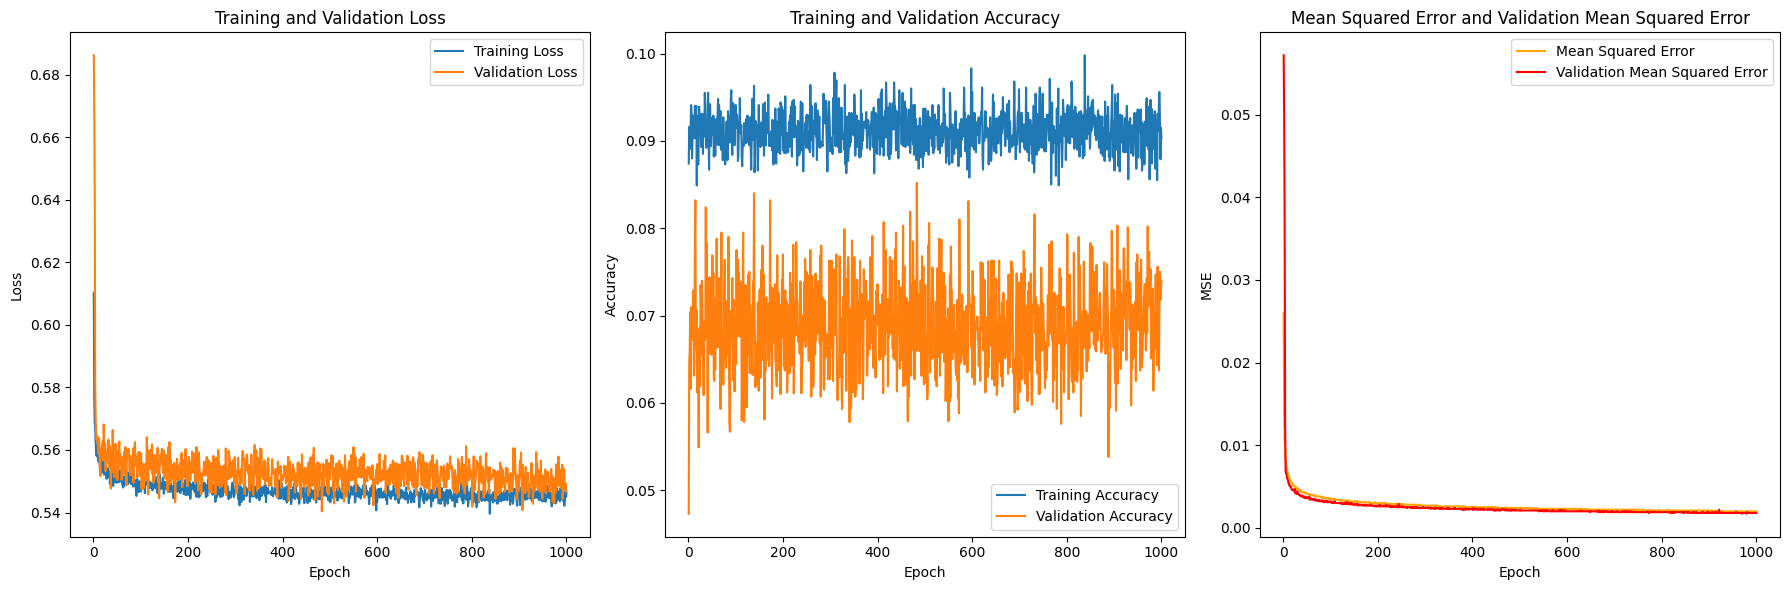


In [ ]:
# Choose a threshold for anomaly detection
threshold = 0.01  # Adjust this threshold based on your evaluation

**Calculating Reconstruction Error On Healthy Scans**

1/1 [==============================] - 0s 231ms/step


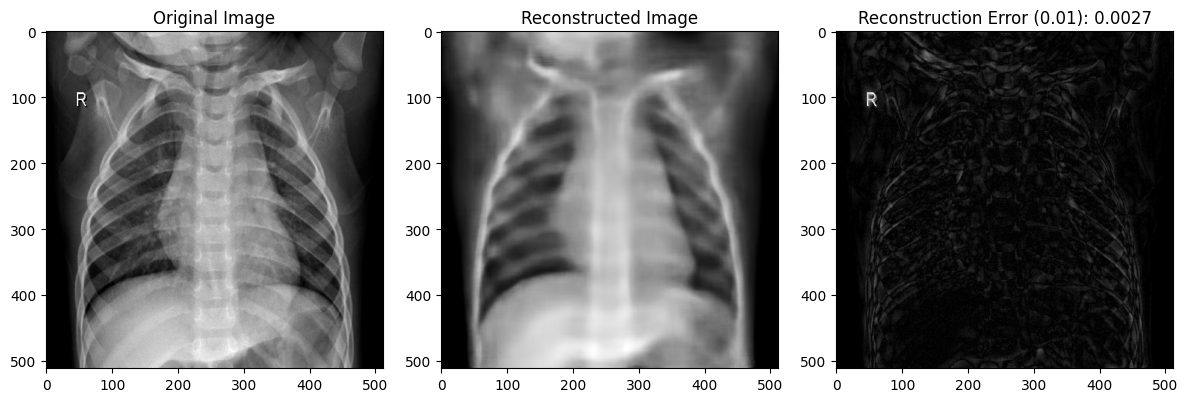

In [ ]:
# Load the autoencoder model
autoencoder_model_path = '/content/models/4/autoencoder_model_crops_cross_1000e.h5'
autoencoder = load_model(autoencoder_model_path)
# model_full_report(autoencoder,history, test_generator_sick)
# Load the original image
image_path = '/content/dataset/chest_xray/train/NORMAL/IM-0117-0001.jpeg'
img = image.load_img(image_path, target_size=(512, 512), color_mode='grayscale')
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Get the reconstructed image from the autoencoder
reconstructed_img = autoencoder.predict(img_array)

# Compute the reconstruction error
reconstruction_error = np.mean(np.square(reconstructed_img - img_array))

# Display the images and information with thresholding
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_img[0, :, :, 0], cmap='gray')
plt.title('Reconstructed Image')

# Reconstruction Error with Threshold
plt.subplot(1, 3, 3)
error_image = np.abs(reconstructed_img[0, :, :, 0] - img_array[0, :, :, 0])
thresholded_error = np.where(error_image > threshold, error_image, 0)
plt.imshow(thresholded_error, cmap='gray')
plt.title(f'Reconstruction Error ({threshold}): {reconstruction_error:.4f}')

plt.tight_layout()
plt.savefig('reconstruction_error_cross_1.png')
plt.show()

**Calculating Reconstruction Error On Anomaly Scans**

1/1 [==============================] - 0s 225ms/step


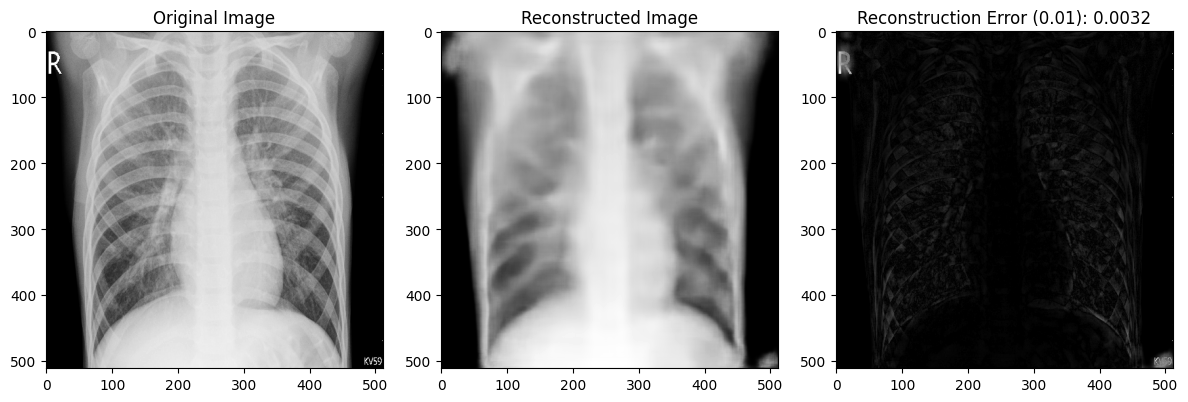

In [ ]:
# Load the autoencoder model
autoencoder_model_path = '/content/models/4/autoencoder_model_crops_cross_1000e.h5'
autoencoder = load_model(autoencoder_model_path)
# model_full_report(autoencoder,history, test_generator_sick)
# Load the original image
image_path = '/content/dataset/chest_xray/train/PNEUMONIA/person1077_virus_1787.jpeg'
img = image.load_img(image_path, target_size=(512, 512), color_mode='grayscale')
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Get the reconstructed image from the autoencoder
reconstructed_img = autoencoder.predict(img_array)

# Compute the reconstruction error
reconstruction_error = np.mean(np.square(reconstructed_img - img_array))


# Display the images and information with thresholding
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_img[0, :, :, 0], cmap='gray')
plt.title('Reconstructed Image')

# Reconstruction Error with Threshold
plt.subplot(1, 3, 3)
error_image = np.abs(reconstructed_img[0, :, :, 0] - img_array[0, :, :, 0])
thresholded_error = np.where(error_image > threshold, error_image, 0)
plt.imshow(thresholded_error, cmap='gray')
plt.title(f'Reconstruction Error ({threshold}): {reconstruction_error:.4f}')

plt.tight_layout()
plt.savefig('reconstruction_error_cross_anomaly.png')
plt.show()

**Calculating Reconstruction Error On Random Image**

1/1 [==============================] - 1s 701ms/step


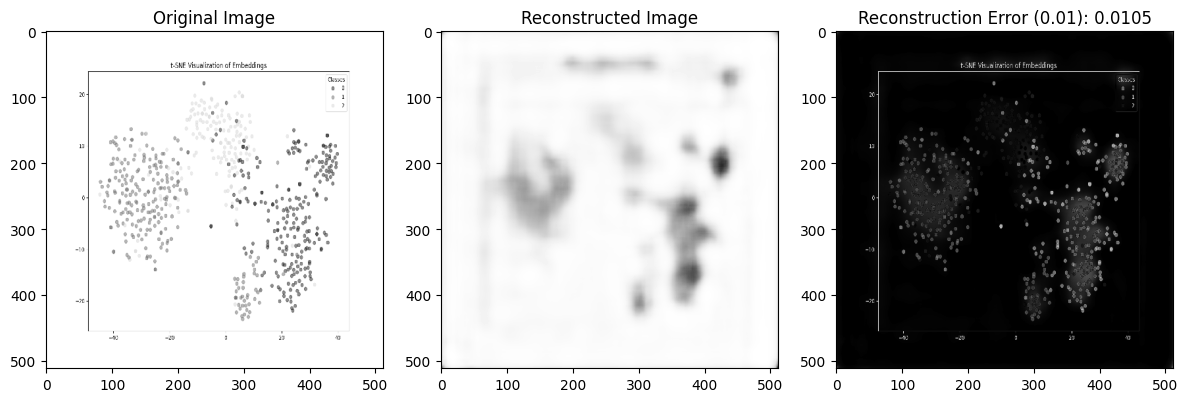

In [ ]:
# Load the autoencoder model
autoencoder_model_path = '/content/models/4/autoencoder_model_crops_cross_1000e.h5'
autoencoder = load_model(autoencoder_model_path)
# model_full_report(autoencoder,history, test_generator_sick)
# Load the original image
image_path = '/content/tsne.png'
img = image.load_img(image_path, target_size=(512, 512), color_mode='grayscale')
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Get the reconstructed image from the autoencoder
reconstructed_img = autoencoder.predict(img_array)

# Compute the reconstruction error
reconstruction_error = np.mean(np.square(reconstructed_img - img_array))

# Display the images and information with thresholding
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_img[0, :, :, 0], cmap='gray')
plt.title('Reconstructed Image')

# Reconstruction Error with Threshold
plt.subplot(1, 3, 3)
error_image = np.abs(reconstructed_img[0, :, :, 0] - img_array[0, :, :, 0])
thresholded_error = np.where(error_image > threshold, error_image, 0)
plt.imshow(thresholded_error, cmap='gray')
plt.title(f'Reconstruction Error ({threshold}): {reconstruction_error:.4f}')

plt.tight_layout()
plt.savefig('reconstruction_error_cross_anomaly.png')
plt.show()

Heatmap Anomaly Detection

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Set paths
train_data_dir = '/content/dataset/chest_xray/train'
test_data_dir = '/content/dataset/chest_xray/test'

# Define parameters for the data generator
img_width, img_height = 512, 512  # Adjust the size based on your model requirements
batch_size = 16

# Create an ImageDataGenerator for testing
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='input',  # Input and target are the same (autoencoder)
                                                  color_mode='grayscale',
                                                  classes=['NORMAL'])
anomaly_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='input',  # Input and target are the same (autoencoder)
                                                  color_mode='grayscale',
                                                  classes=['PNEUMONIA'])

# Load the trained autoencoder
autoencoder = load_model('/content/models/4/autoencoder_model_crops_cross_1000e.h5')
autoencoder.load_weights('/content/models/4/autoencoder_model_crops_cross_1000e.h5')

# Function to generate heatmap
def generate_heatmap(original_img, reconstructed_img, threshold):
    mse = np.mean((original_img - reconstructed_img)**2, axis=-1)
    anomaly_mask = mse > threshold
    return anomaly_mask

# Load an example image for testing
example_img, _ = test_generator.next()
anomaly_img, _ = anomaly_generator.next()

# Reconstruct the image using the autoencoder
reconstructed_img = autoencoder.predict(example_img)
reconstructed_img_anomaly = autoencoder.predict(anomaly_img)

# Generate the anomaly heatmap
heatmap = generate_heatmap(example_img, reconstructed_img, threshold)


def plot_combined_images_and_heatmap(original_img, reconstructed_img, heatmap, title_prefix):
    plt.figure(figsize=(15, 5 * batch_size))

    for i in range(batch_size):
        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(np.squeeze(original_img[i]), cmap='gray')
        plt.title('Original Image')

        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(np.squeeze(reconstructed_img[i]), cmap='gray')
        plt.title('Reconstructed Image')

        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(np.squeeze(original_img[i]), cmap='gray')
        plt.imshow(heatmap[i], cmap='jet', alpha=0.5)
        plt.title('Anomaly Heatmap')

    plt.tight_layout()
    plt.suptitle(title_prefix + ' Anomaly', y=1.02)
    plt.show()

# Plot for normal case
plot_combined_images_and_heatmap(example_img, reconstructed_img, heatmap, 'Normal')

# Generate the anomaly heatmap
heatmap_anomaly = generate_heatmap(anomaly_img, reconstructed_img_anomaly, threshold)

# Plot for anomaly case
plot_combined_images_and_heatmap(anomaly_img, reconstructed_img_anomaly, heatmap_anomaly, 'Anomaly')


Output hidden; open in https://colab.research.google.com to view.

Reconstruction Error graph on healthy and sick scans.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the trained autoencoder
autoencoder = load_model('/content/models/4/autoencoder_model_crops_cross_1000e.h5')
autoencoder.load_weights('/content/models/4/autoencoder_model_crops_cross_1000e.h5')

# Get the number of samples in the test set
num_healthy_samples = test_generator.samples
num_sick_samples = anomaly_generator.samples

# Initialize an array to store the reconstruction errors
reconstruction_errors_healthy = np.zeros(num_healthy_samples)
reconstruction_errors_sick = np.zeros(num_sick_samples)

# Calculate reconstruction errors for healthy images
counter = 0
healthy_iterator = iter(test_generator)
try:
    while True:
        img, _ = next(healthy_iterator)
        for j in range(len(img)):
            im = img[j]
            im = np.expand_dims(im, axis=0)
            reconstructed_img = autoencoder.predict(im)
            error = np.mean((im - reconstructed_img)**2)
            reconstruction_errors_healthy[counter] = error
            counter += 1
except StopIteration:
    pass
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Reset the counter for sick images
counter = 0
sick_iterator = iter(anomaly_generator)
try:
    while True:
        img, _ = next(sick_iterator)
        for j in range(len(img)):
            im = img[j]
            im = np.expand_dims(im, axis=0)
            reconstructed_img = autoencoder.predict(im)
            error = np.mean((im - reconstructed_img)**2)
            reconstruction_errors_sick[counter] = error
            counter += 1
except StopIteration:
    pass
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(range(num_healthy_samples), reconstruction_errors_healthy, color='orange', label='Healthy')
plt.scatter(range(num_healthy_samples, num_healthy_samples + num_sick_samples),
            reconstruction_errors_sick, color='blue', label='Sick')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors for Healthy and Sick Images')
plt.legend()
plt.show()


1/1 [==============================] - 0s 20ms/step


Reconstruction Error Distributions for healthy and sick with ROC Curve graph.


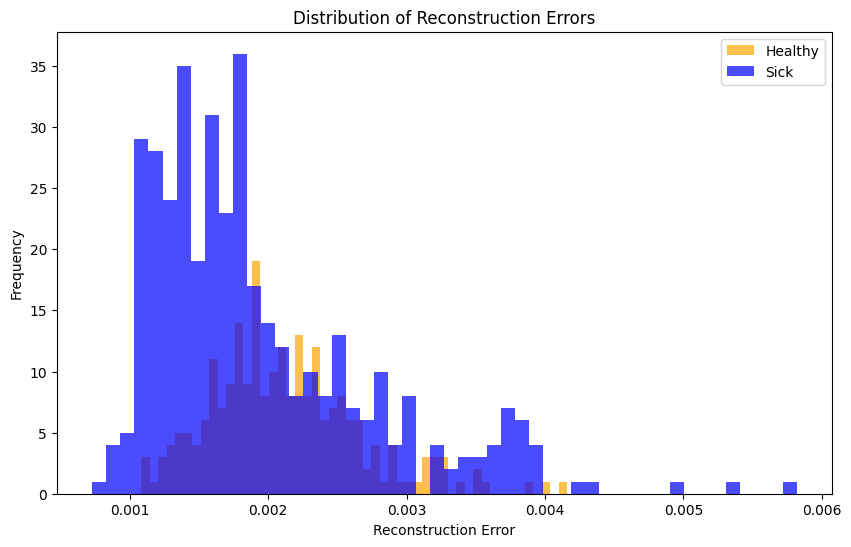

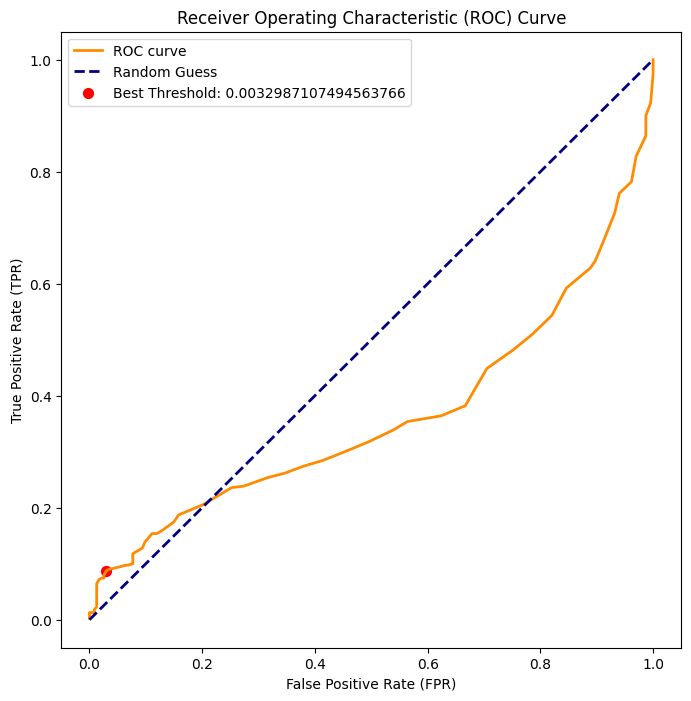

Best Threshold (Youden's J): 0.0032987107494563766


In [ ]:
# Concatenate the reconstruction errors for healthy and sick samples
all_errors = np.concatenate([reconstruction_errors_healthy, reconstruction_errors_sick])

# Plot the distribution of reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors_healthy, bins=50, color='orange', alpha=0.7, label='Healthy')
plt.hist(reconstruction_errors_sick, bins=50, color='blue', alpha=0.7, label='Sick')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

# Experiment with different threshold values
thresholds = np.linspace(min(all_errors), max(all_errors), 100)
tpr_values = []
fpr_values = []

for threshold in thresholds:
    true_positives = np.sum(reconstruction_errors_sick >= threshold)
    false_negatives = np.sum(reconstruction_errors_sick < threshold)
    true_negatives = np.sum(reconstruction_errors_healthy < threshold)
    false_positives = np.sum(reconstruction_errors_healthy >= threshold)

    tpr = true_positives / (true_positives + false_negatives)
    fpr = false_positives / (false_positives + true_negatives)

    tpr_values.append(tpr)
    fpr_values.append(fpr)

# Convert lists to NumPy arrays
tpr_values = np.array(tpr_values)
fpr_values = np.array(fpr_values)

# Calculate the Youden's J statistic for each threshold
youden_values = tpr_values - fpr_values

# Find the threshold that maximizes the Youden's J statistic
best_threshold_index = np.argmax(youden_values)
best_threshold = thresholds[best_threshold_index]

# Plot the ROC curve with the selected threshold
plt.figure(figsize=(8, 8))
plt.plot(fpr_values, tpr_values, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr_values[best_threshold_index], tpr_values[best_threshold_index], color='red', s=50, label=f'Best Threshold: {best_threshold}')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(f"Best Threshold (Youden's J): {best_threshold}")

Checking For Accuracy with the new found best_threshold

In [ ]:
# Classify samples based on the selected threshold
predicted_labels_healthy = reconstruction_errors_healthy < best_threshold
predicted_labels_sick = reconstruction_errors_sick >= best_threshold

# True labels (1 for sick, 0 for healthy)
true_labels_healthy = np.zeros(num_healthy_samples)
true_labels_sick = np.ones(num_sick_samples)

# Concatenate true and predicted labels
all_true_labels = np.concatenate([true_labels_healthy, true_labels_sick])
all_predicted_labels = np.concatenate([predicted_labels_healthy, predicted_labels_sick])

# Calculate accuracy
accuracy = np.sum(all_true_labels == all_predicted_labels) / len(all_true_labels)

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 6.57%
